# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

## Part 1 - Preprocessing and encoding

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Task 1.csv')
df.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

def encode_features(ds, features_to_encode):
  encoder = OneHotEncoder(sparse=False)
  encoder.fit(ds[features_to_encode])

  new_feats = encoder.transform(ds[features_to_encode])
  # create dataset from encoded features with named columns
  new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_to_encode))
  new_ds = pd.concat([ds, new_cols], axis=1)    
  new_ds.drop(features_to_encode, axis=1, inplace=True)
  return new_ds

def encode_ordinal_features(ds, features_to_encode):
  encoder = OrdinalEncoder()
  encoder.fit(ds[features_to_encode])

  new_feats = encoder.transform(ds[features_to_encode])
  # create dataset from encoded features with named columns
  new_cols = pd.DataFrame(new_feats, dtype=int, columns=list(map(lambda x: x + "_encoded", features_to_encode)))
  new_ds = pd.concat([ds, new_cols], axis=1)    
  new_ds.drop(features_to_encode, axis=1, inplace=True)
  return new_ds


def scale_data(x_train, x_test):
  scaler = MinMaxScaler()
  scaler.fit(x_train)
  
  x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
  return (x_train, x_test, scaler)

df = encode_features(df, ["race/ethnicity", "parental level of education"])
df = encode_ordinal_features(df, ["gender", "test preparation course", "lunch"])
df.head(5)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,math score,reading score,writing score,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,gender_encoded,test preparation course_encoded,lunch_encoded
0,67,67,63,1,0,0,0,0,0,0,1,0,0,0,1,0,1
1,40,59,55,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2,59,60,50,0,0,0,0,1,0,0,0,0,1,0,1,1,0
3,77,78,68,0,1,0,0,0,0,0,1,0,0,0,1,1,1
4,78,73,68,0,0,0,0,1,1,0,0,0,0,0,1,0,1


Splitting data

In [ ]:
df_x = df.iloc[:,3:]
df_y  = df.iloc[:,:3] / 100
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
      df_x, df_y, test_size = 0.2, random_state=28)

df_x_train, df_x_test, _ = scale_data(df_x_train, df_x_test)

Creating pytorch dataset


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CustumData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


train_dataset = CustumData(df_x_train.values, df_y_train.values)
test_dataset = CustumData(df_x_test.values, df_y_test.values) 

train_dataloader = DataLoader(train_dataset, 128, shuffle=True)
test_dataloader = DataLoader(test_dataset, 128, shuffle=False)

data, label = next(iter(train_dataloader))
label.shape

torch.Size([128, 3])

Creating a model:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from time import time 

class ANN_model(nn.Module):
    def __init__(self, layers_and_neurons = [64, 64], activation_function = F.leaky_relu):
        super(ANN_model, self).__init__()
        self.input_layer = nn.Linear(14, layers_and_neurons[0])
        for i in range(0, len(layers_and_neurons) - 1):
          self.layers.append(nn.Linear(layers_and_neurons[i], layers_and_neurons[i + 1]))
        self.output_layer = nn.Linear(layers_and_neurons[-1], 3)
        self.activation_function = activation_function
    
    def forward(self, x):
        x = self.activation_function(self.input_layer(x))
        for i in range(0, len(self.layers)):
          x = self.activation_function(self.layers[i](x))
        x = self.output_layer(x)
        return x

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

import operator
import numpy as np
import tensorflow as tf
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    log_interval = 10

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #print(f'Target: {target}')
        #print(f'Output: {output}')


        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f'\rTrain Epoch {epoch}:',
                  f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                  f'({100. * batch_idx / len(train_loader):.0f}%)]',
                  f'\tLoss: {loss.item():.6f}',
                  end='')
         
    print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss/len(train_loader.dataset):.6f}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss

def test( model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    mse_loss = 0
    mae_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            mse_loss += F.mse_loss(output, target, reduction='sum').item()
            test_loss += F.l1_loss(output, target, reduction='sum').item()  # sum up batch loss
            #print(f'Target: {target}')
            #print(f'Output: {output}')

    print(f'\rTest set: Average loss: {test_loss/len(test_loader.dataset):.4f}')
    
    return test_loss, mse_loss

  

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy

def check_model(model, device, test_dataloader, train_dataloader):
  writer = SummaryWriter(log_dir='runs/model')

  epochs = 100
  lr = 0.1  # will start with big LR to see the lr_scheduler work
  momentum = 0.5
  log_interval = 10

  criterion = nn.L1Loss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)
  early_stopping = EarlyStopping(tolerance=7, mode='min')

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss, best_mse, best_mae = 10000, 120, 200

  for epoch in range(1, epochs + 1):
      train_loss = train(model, device, train_dataloader, criterion, optimizer, epoch)
      scheduler.step(train_loss)

      test_loss, test_mse = test(model, device, test_dataloader, criterion)
      if early_stopping(test_loss):
        print('\nEarly stopping\n')
        break

      writer.add_scalars('Loss',
                          {
                              'train': train_loss,
                              'test': test_loss
                          },
                          epoch)
      if test_loss < best_loss:
          best_loss = test_loss
          best_mse = test_mse
          best_model_wts = copy.deepcopy(model.state_dict())

  writer.close()
  # we can also save every X epochs, so if our machine crashes we don't lose our progress
  torch.save(model.state_dict(), "model.pt")

  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), "best_model.pt")
  return best_loss, best_mse

#check_model(ANN_model(), test_dataloader, train_dataloader)

### Tuning model

In [ ]:
import random
# checking amount of layers

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

three_layer_model = ANN_model().to(device)
print(three_layer_model)
three_layer_loss, three_layer_mse = check_model(three_layer_model, device, test_dataloader, train_dataloader)

ANN_model(
  (input_layer): Linear(in_features=14, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
Train Epoch: 1 Average Loss: 0.003356, elapsed time:0.01s
Test set: Average loss: 0.9576
Train Epoch: 2 Average Loss: 0.002116, elapsed time:0.01s
Test set: Average loss: 0.6016
Train Epoch: 3 Average Loss: 0.001449, elapsed time:0.01s
Test set: Average loss: 0.4637
Train Epoch: 4 Average Loss: 0.001207, elapsed time:0.02s
Test set: Average loss: 0.4327
Train Epoch: 5 Average Loss: 0.001094, elapsed time:0.01s
Test set: Average loss: 0.3650
Train Epoch: 6 Average Loss: 0.001034, elapsed time:0.01s
Test set: Average loss: 0.3501
Train Epoch: 7 Average Loss: 0.001002, elapsed time:0.01s
Test set: Average loss: 0.3378
Train Epoch: 8 Average Loss: 0.000956, elapsed time:0.01s
Test set: Average loss: 0.3228
Train Epoch: 9 Average Loss: 0.000940, elapsed time:0.01s
Test set: Average loss: 0.3213
Train Epoch: 10 Average Loss: 0.000932, elapsed ti

In [ ]:
fifty_layer_model = ANN_model(layers_and_neurons = [random.randrange(512) for i in range(50)]).to(device)
fifty_layer_loss, fifty_layer_mse = check_model(fifty_layer_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003566, elapsed time:0.38s
Test set: Average loss: 0.8725
Train Epoch: 2 Average Loss: 0.002512, elapsed time:0.37s
Test set: Average loss: 0.4684
Train Epoch: 3 Average Loss: 0.001635, elapsed time:0.39s
Test set: Average loss: 0.4179
Train Epoch: 4 Average Loss: 0.001321, elapsed time:0.37s
Test set: Average loss: 0.4298
Train Epoch: 5 Average Loss: 0.001230, elapsed time:0.36s
Test set: Average loss: 0.3971
Train Epoch: 6 Average Loss: 0.001123, elapsed time:0.38s
Test set: Average loss: 0.3877
Train Epoch: 7 Average Loss: 0.001081, elapsed time:0.40s
Test set: Average loss: 0.3808
Train Epoch: 8 Average Loss: 0.001096, elapsed time:0.38s
Test set: Average loss: 0.3801
Train Epoch: 9 Average Loss: 0.001061, elapsed time:0.36s
Test set: Average loss: 0.3784
Train Epoch: 10 Average Loss: 0.001062, elapsed time:0.37s
Test set: Average loss: 0.3790
Train Epoch: 11 Average Loss: 0.001078, elapsed time:0.37s
Test set: Average loss: 0.3776
Train Epoch: 12 Ave

In [ ]:
thousand_layer_model = ANN_model(layers_and_neurons = [random.randrange(512) for i in range(50)]).to(device)
thousand_layer_loss, thousand_layer_mse = check_model(thousand_layer_model, device, test_dataloader, train_dataloader)

print("\n\n\n\n")
print(f'\n Three layer model L1 loss: {three_layer_loss}, mse: {three_layer_mse}',
          f'\n Fifty layer model L1 loss: {fifty_layer_loss}, mse: {fifty_layer_mse},', 
          f'\n Thousamd layer model L1 loss: {thousand_layer_loss}, mse: {thousand_layer_mse}')

Train Epoch 1: [0/800 (0%)] 	Loss: 0.632802

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Train Epoch: 1 Average Loss: 0.003717, elapsed time:0.35s
Test set: Average loss: 0.4519
Train Epoch: 2 Average Loss: 0.002317, elapsed time:0.36s
Test set: Average loss: 0.5311
Train Epoch: 3 Average Loss: 0.001519, elapsed time:0.36s
Test set: Average loss: 0.5420
Train Epoch: 4 Average Loss: 0.001357, elapsed time:0.35s
Test set: Average loss: 0.4599
Train Epoch: 5 Average Loss: 0.001230, elapsed time:0.35s
Test set: Average loss: 0.4408
Train Epoch: 6 Average Loss: 0.001160, elapsed time:0.36s
Test set: Average loss: 0.3942
Train Epoch: 7 Average Loss: 0.001138, elapsed time:0.36s
Test set: Average loss: 0.3923
Train Epoch: 8 Average Loss: 0.001101, elapsed time:0.35s
Test set: Average loss: 0.3778
Train Epoch: 9 Average Loss: 0.001086, elapsed time:0.35s
Test set: Average loss: 0.3786
Train Epoch: 10 Average Loss: 0.001105, elapsed time:0.36s
Test set: Average loss: 0.3787
Train Epoch: 11 Average Loss: 0.001077, elapsed time:0.36s
Test set: Average loss: 0.3784
Train Epoch: 12 Ave

In [ ]:
ten_neuron_model = ANN_model(layers_and_neurons=[20, 64, 14]).to(device)
ten_neuron_loss, ten_neuron_mse = check_model(ten_neuron_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003457, elapsed time:0.01s
Test set: Average loss: 0.5576
Train Epoch: 2 Average Loss: 0.002117, elapsed time:0.01s
Test set: Average loss: 0.5404
Train Epoch: 3 Average Loss: 0.001578, elapsed time:0.01s
Test set: Average loss: 0.4867
Train Epoch: 4 Average Loss: 0.001339, elapsed time:0.02s
Test set: Average loss: 0.4177
Train Epoch: 5 Average Loss: 0.001198, elapsed time:0.01s
Test set: Average loss: 0.4106
Train Epoch: 6 Average Loss: 0.001122, elapsed time:0.01s
Test set: Average loss: 0.3846
Train Epoch: 7 Average Loss: 0.001104, elapsed time:0.01s
Test set: Average loss: 0.3865
Train Epoch: 8 Average Loss: 0.001087, elapsed time:0.02s
Test set: Average loss: 0.3731
Train Epoch: 9 Average Loss: 0.001092, elapsed time:0.01s
Test set: Average loss: 0.3754
Train Epoch: 10 Average Loss: 0.001048, elapsed time:0.01s
Test set: Average loss: 0.3709
Train Epoch: 11 Average Loss: 0.001074, elapsed time:0.01s
Test set: Average loss: 0.3719
Train Epoch: 12 Ave

In [ ]:
hundred_neuron_model = ANN_model(layers_and_neurons=[128, 512, 256]).to(device)
hundred_neuron_loss, hundred_neuron_mse = check_model(hundred_neuron_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003512, elapsed time:0.03s
Test set: Average loss: 0.7587
Train Epoch: 2 Average Loss: 0.002207, elapsed time:0.03s
Test set: Average loss: 0.4379
Train Epoch: 3 Average Loss: 0.001435, elapsed time:0.03s
Test set: Average loss: 0.3873
Train Epoch: 4 Average Loss: 0.001309, elapsed time:0.03s
Test set: Average loss: 0.3909
Train Epoch: 5 Average Loss: 0.001200, elapsed time:0.03s
Test set: Average loss: 0.3625
Train Epoch: 6 Average Loss: 0.001115, elapsed time:0.03s
Test set: Average loss: 0.3689
Train Epoch: 7 Average Loss: 0.001051, elapsed time:0.03s
Test set: Average loss: 0.3509
Train Epoch: 8 Average Loss: 0.001013, elapsed time:0.03s
Test set: Average loss: 0.3501
Train Epoch: 9 Average Loss: 0.000985, elapsed time:0.04s
Test set: Average loss: 0.3344
Train Epoch: 10 Average Loss: 0.000989, elapsed time:0.03s
Test set: Average loss: 0.3316
Train Epoch: 11 Average Loss: 0.000952, elapsed time:0.03s
Test set: Average loss: 0.3227
Train Epoch: 12 Ave

In [ ]:
thousand_neuron_model = ANN_model(layers_and_neurons=[2048, 5000, 1024]).to(device)
thousand_neuron_loss, thousand_neuron_mse = check_model(thousand_neuron_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003235, elapsed time:1.29s
Test set: Average loss: 1.1461
Train Epoch: 2 Average Loss: 0.002215, elapsed time:1.29s
Test set: Average loss: 0.8089
Train Epoch: 3 Average Loss: 0.001618, elapsed time:1.28s
Test set: Average loss: 0.4994
Train Epoch: 4 Average Loss: 0.001324, elapsed time:1.28s
Test set: Average loss: 0.3497
Train Epoch: 5 Average Loss: 0.001114, elapsed time:1.27s
Test set: Average loss: 0.3777
Train Epoch: 6 Average Loss: 0.000986, elapsed time:1.27s
Test set: Average loss: 0.3309
Train Epoch: 7 Average Loss: 0.000956, elapsed time:1.29s
Test set: Average loss: 0.3110
Train Epoch: 8 Average Loss: 0.000952, elapsed time:1.28s
Test set: Average loss: 0.3181
Train Epoch: 9 Average Loss: 0.000941, elapsed time:1.28s
Test set: Average loss: 0.3083
Train Epoch: 10 Average Loss: 0.000916, elapsed time:1.54s
Test set: Average loss: 0.3113
Train Epoch: 11 Average Loss: 0.000934, elapsed time:1.28s
Test set: Average loss: 0.3005
Train Epoch: 12 Ave

In [ ]:
print(f'\rTen neuron model L1 loss: {ten_neuron_loss}, mse: {ten_neuron_mse}',
          f'\n Hundred neuron model L1 loss: {hundred_neuron_loss}, mse: {hundred_neuron_mse}', 
          f'\n Thousamd neuron model L1 loss: {thousand_neuron_loss}, mse: {thousand_neuron_mse}')

Ten neuron model L1 loss: 68.4075927734375, mse: 11.78477168083191 
 Hundred neuron model L1 loss: 60.65543556213379, mse: 9.514414310455322 
 Thousamd neuron model L1 loss: 60.099090576171875, mse: 9.323148965835571


In [ ]:
relu_model = ANN_model(layers_and_neurons=[2048, 5000, 1024], activation_function = F.relu).to(device)
relu_loss, relu_mse  = check_model(relu_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003435, elapsed time:1.28s
Test set: Average loss: 1.2160
Train Epoch: 2 Average Loss: 0.002222, elapsed time:1.31s
Test set: Average loss: 0.7475
Train Epoch: 3 Average Loss: 0.001665, elapsed time:1.30s
Test set: Average loss: 0.3753
Train Epoch: 4 Average Loss: 0.001244, elapsed time:1.67s
Test set: Average loss: 0.3787
Train Epoch: 5 Average Loss: 0.001089, elapsed time:1.28s
Test set: Average loss: 0.3738
Train Epoch: 6 Average Loss: 0.000945, elapsed time:1.80s
Test set: Average loss: 0.3126
Train Epoch: 7 Average Loss: 0.000943, elapsed time:1.28s
Test set: Average loss: 0.3081
Train Epoch: 8 Average Loss: 0.000932, elapsed time:1.28s
Test set: Average loss: 0.3060
Train Epoch: 9 Average Loss: 0.000884, elapsed time:1.27s
Test set: Average loss: 0.3165
Train Epoch: 10 Average Loss: 0.000906, elapsed time:1.63s
Test set: Average loss: 0.3013
Train Epoch: 11 Average Loss: 0.000904, elapsed time:1.61s
Test set: Average loss: 0.3010
Train Epoch: 12 Ave

In [ ]:
leaky_relu_model = ANN_model(layers_and_neurons=[2048, 5000, 1024], activation_function = F.leaky_relu).to(device)
leaky_relu_loss, leaky_relu_mse = check_model(leaky_relu_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.003306, elapsed time:1.27s
Test set: Average loss: 1.2253
Train Epoch: 2 Average Loss: 0.002320, elapsed time:1.28s
Test set: Average loss: 0.7982
Train Epoch: 3 Average Loss: 0.001608, elapsed time:1.29s
Test set: Average loss: 0.3791
Train Epoch: 4 Average Loss: 0.001219, elapsed time:1.27s
Test set: Average loss: 0.3824
Train Epoch: 5 Average Loss: 0.001106, elapsed time:1.26s
Test set: Average loss: 0.3848
Train Epoch: 6 Average Loss: 0.001035, elapsed time:1.28s
Test set: Average loss: 0.3309
Train Epoch: 7 Average Loss: 0.001003, elapsed time:1.26s
Test set: Average loss: 0.3186
Train Epoch: 8 Average Loss: 0.000971, elapsed time:1.25s
Test set: Average loss: 0.3017
Train Epoch: 9 Average Loss: 0.000937, elapsed time:1.27s
Test set: Average loss: 0.3061
Train Epoch: 10 Average Loss: 0.000900, elapsed time:1.27s
Test set: Average loss: 0.3581
Train Epoch: 11 Average Loss: 0.000974, elapsed time:1.29s
Test set: Average loss: 0.3010
Train Epoch: 12 Ave

In [ ]:
print(f'\nAverage relu L1 loss: {relu_loss}, mse: {relu_mse}',
          f'\nAverage leaky relu L1 loss: {leaky_relu_loss}, mse: {leaky_relu_mse}')

\Average relu L1 loss: 60.19511604309082, mse: 9.347373485565186 Average leaky relu L1 loss: 59.110633850097656, mse: 9.132680416107178


In [ ]:
class Best_ANN_model(nn.Module):
    def __init__(self):
        super(Best_ANN_model, self).__init__()
        self.input_layer = nn.Linear(14, 2048)
        self.hidden1 = nn.Linear(2048, 5000)
        self.hidden2 = nn.Linear(5000, 1024)
        self.output_layer = nn.Linear(1024, 3)
    
    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x))
        x = F.leaky_relu(self.hidden1(x))
        x = F.leaky_relu(self.hidden2(x))
        x = self.output_layer(x)
        return x

final_model = Best_ANN_model().to(device)
final_loss, final_mse = check_model(final_model, device, test_dataloader, train_dataloader)

Train Epoch: 1 Average Loss: 0.002808, elapsed time:1.59s
Test set: Average loss: 0.5445
Train Epoch: 2 Average Loss: 0.001343, elapsed time:1.56s
Test set: Average loss: 0.3706
Train Epoch: 3 Average Loss: 0.001092, elapsed time:1.56s
Test set: Average loss: 0.3651
Train Epoch: 4 Average Loss: 0.001106, elapsed time:1.54s
Test set: Average loss: 0.3741
Train Epoch: 5 Average Loss: 0.001045, elapsed time:1.54s
Test set: Average loss: 0.3334
Train Epoch: 6 Average Loss: 0.000939, elapsed time:1.52s
Test set: Average loss: 0.3261
Train Epoch: 7 Average Loss: 0.000968, elapsed time:1.56s
Test set: Average loss: 0.3490
Train Epoch: 8 Average Loss: 0.000916, elapsed time:1.55s
Test set: Average loss: 0.3088
Train Epoch: 9 Average Loss: 0.000882, elapsed time:1.52s
Test set: Average loss: 0.3083
Train Epoch: 10 Average Loss: 0.000869, elapsed time:1.55s
Test set: Average loss: 0.3048
Train Epoch: 11 Average Loss: 0.000858, elapsed time:1.53s
Test set: Average loss: 0.3097
Train Epoch: 12 Ave

In [ ]:
print(f'\Final L1 loss: {relu_loss}, mse: {relu_mse}')

\Final L1 loss: 60.19511604309082, mse: 9.347373485565186


### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [7]:

!unzip triple_mnist.zip

Archive:  triple_mnist.zip
replace triple_mnist/test/002/0_002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import os
from torchvision.datasets  import ImageFolder
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import random

class MyImageDataSet(ImageFolder):
  def __init__(self, root, transform=None):
      super().__init__(root, transform)
  
  def find_classes(self, directory: str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: int(cls_name) for i, cls_name in enumerate(classes)}
    return classes, class_to_idx 

train_dataset = MyImageDataSet(root='triple_mnist/train', 
                             transform=T.Compose([T.ToTensor(), T.Grayscale(), T.RandomRotation(degrees=(-3, 3))]))
train_dataloader = data.DataLoader(dataset=train_dataset,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=1)


val_dataset = MyImageDataSet(root='triple_mnist/val', 
                             transform=T.Compose([T.ToTensor(), T.Grayscale()]))
val_dataloader = data.DataLoader(dataset=val_dataset,
                                  batch_size=32,
                                  shuffle=False,
                                  num_workers=1)


test_dataset = MyImageDataSet(root='triple_mnist/test', 
                             transform=T.Compose([T.ToTensor(), T.Grayscale()]))
test_dataloader = data.DataLoader(dataset=test_dataset,
                                  batch_size=32,
                                  shuffle=False,
                                  num_workers=1)



Feature batch shape: torch.Size([32, 1, 84, 84])
Labels batch shape: torch.Size([32])


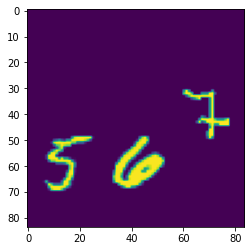

Label: 567


In [3]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from time import time 
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import copy

class ANN_img_model(nn.Module):
    def __init__(self):
        super(ANN_img_model, self).__init__()
        self.flatten = nn.Flatten()
        self.adapter = nn.Linear(84*84, 14)
        self.input_layer = nn.Linear(14, 2048)
        self.hidden1 = nn.Linear(2048, 5000)
        self.hidden2 = nn.Linear(5000, 1024)
        self.output_1 = nn.Linear(1024, 10)
        self.output_2 = nn.Linear(1024, 10)
        self.output_3 = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.adapter(x)
        x = F.leaky_relu(self.input_layer(x))
        x = F.leaky_relu(self.hidden1(x))
        x = F.leaky_relu(self.hidden2(x))
        return [self.output_1(x), self.output_2(x), self.output_3(x)]

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


import operator
import numpy as np
import tensorflow as tf
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

def customLoss(pred, target):
    fir = F.cross_entropy(pred[0], target[0])
    sec = F.cross_entropy(pred[1], target[1])
    thr = F.cross_entropy(pred[2], target[2])
    loss = fir + sec + thr
    return loss

def img_train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    log_interval = 10

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)

        target1 = (target // 100).to(device)
        target2 = ((target // 10) % 10).to(device) 
        target3 = (target % 10).to(device)
        #print(f'base: {target}')
        #print(f'first: {target1}, \n second: {target2}, \n third: {target3}')

        optimizer.zero_grad()
        output = model(data)

        loss = customLoss(output, [target1, target2, target3])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f'\rTrain Epoch {epoch}:',
                  f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                  f'({100. * batch_idx / len(train_loader):.0f}%)]',
                  f'\tLoss: {loss.item()}',
                  end='')
              
    print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss/len(train_loader.dataset):.6f}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss

def img_test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target1 = (target // 100).to(device)
            target2 = ((target // 10) % 10).to(device) 
            target3 = (target % 10).to(device)

            output = model(data)

            fir = torch.max(output[0], 1)[1].data.squeeze()
            sec = torch.max(output[1], 1)[1].data.squeeze()
            thr = torch.max(output[2], 1)[1].data.squeeze()
            temp = torch.mul((fir == target1), (sec == target2))
            temp = torch.mul(temp, (thr == target3))
            correct += temp.sum().item()
            total += target1.size(0)

            test_loss += customLoss(output, [target1, target2, target3]).item()  # sum up batch loss
    
    acc = 100. * correct / total
    print(f'\rTest set: Average loss: {test_loss/len(test_loader.dataset):.4f},',
          f'Accuracy: {correct}/{len(test_loader.dataset)}', 
          f'({acc:.0f}%)\n')
    
    return test_loss, acc



def img_check_model(model, device, test_dataloader, train_dataloader):
  writer = SummaryWriter(log_dir='runs/model')
  epochs = 15
  lr = 5e-2  
  momentum = 0.5
  log_interval = 10

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)
  early_stopping = EarlyStopping(tolerance=7, min_delta=5)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(1, epochs + 1):
      train_loss = img_train(model, device, train_dataloader, criterion, optimizer, epoch)
      scheduler.step(train_loss)

      test_loss, test_acc = img_test(model, device, test_dataloader, criterion)
      if early_stopping(test_loss):
          print('\nEarly stopping\n')
          break

      writer.add_scalars('Loss',
                          {
                              'train': train_loss,
                              'test': test_loss
                          },
                          epoch)
      
      writer.add_scalars('Accuracy',
                          {
                              'test': test_acc
                          },
                          epoch)
    
      # deep copy the model
      if test_acc > best_acc:
          best_acc = test_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  writer.close()
  torch.save(model.state_dict(), "model.pt")

  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), "best_model.pt")
  return best_acc

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Train Epoch: 1 Average Loss: 0.194099, elapsed time:68.35s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Test set: Average loss: 0.1909, Accuracy: 172/16000 (1%)

Train Epoch: 2 Average Loss: 0.184043, elapsed time:67.74s
Test set: Average loss: 0.1775, Accuracy: 291/16000 (2%)

Train Epoch: 3 Average Loss: 0.162469, elapsed time:67.64s
Test set: Average loss: 0.1603, Accuracy: 711/16000 (4%)

Train Epoch: 4 Average Loss: 0.154270, elapsed time:67.82s
Test set: Average loss: 0.1610, Accuracy: 726/16000 (5%)

Train Epoch: 5 Average Loss: 0.152337, elapsed time:67.78s
Test set: Average loss: 0.1527, Accuracy: 777/16000 (5%)

Train Epoch: 6 Average Loss: 0.151853, elapsed time:68.47s
Test set: Average loss: 0.1550, Accuracy: 820/16000 (5%)

Train Epoch: 7 Average Loss: 0.151479, elapsed time:67.97s
Test set: Average loss: 0.1568, Accuracy: 657/16000 (4%)

Train Epoch: 8 Average Loss: 0.152269, elapsed time:74.87s
Test set: Average loss: 0.1582, Accuracy: 759/16000 (5%)

Train Epoch: 9 Average Loss: 0.152344, elapsed time:69.60s
Test set: Average loss: 0.1582, Accuracy: 786/16000 (5%)

Train 

8.3625

In [ ]:
ANN_model = ANN_img_model().to(device)
img_check_model(ANN_model, device, val_dataloader, train_dataloader)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out1 = nn.Linear(14112, 10)
        self.out2 = nn.Linear(14112, 10)
        self.out3 = nn.Linear(14112, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return [
            self.out1(x),
            self.out2(x),
            self.out3(x)
        ]

model = CNN().to(device)
img_check_model(model, device, val_dataloader, train_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Train Epoch: 1 Average Loss: 0.055517, elapsed time:64.10s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Test set: Average loss: 0.0328, Accuracy: 11647/16000 (73%)

Train Epoch: 2 Average Loss: 0.023351, elapsed time:63.73s
Test set: Average loss: 0.0236, Accuracy: 12533/16000 (78%)

Train Epoch: 3 Average Loss: 0.018618, elapsed time:63.84s
Test set: Average loss: 0.0280, Accuracy: 12767/16000 (80%)

Train Epoch: 4 Average Loss: 0.019231, elapsed time:63.97s
Test set: Average loss: 0.0363, Accuracy: 12720/16000 (80%)

Train Epoch: 5 Average Loss: 0.022872, elapsed time:64.13s
Test set: Average loss: 0.0329, Accuracy: 12938/16000 (81%)

Train Epoch: 6 Average Loss: 0.024377, elapsed time:63.62s
Test set: Average loss: 0.0448, Accuracy: 12067/16000 (75%)

Train Epoch: 7 Average Loss: 0.030824, elapsed time:63.48s
Epoch 00007: reducing learning rate of group 0 to 1.5000e-02.
Test set: Average loss: 0.0571, Accuracy: 11947/16000 (75%)

Train Epoch: 8 Average Loss: 0.010195, elapsed time:63.96s
Test set: Average loss: 0.0245, Accuracy: 14077/16000 (88%)

Train Epoch: 9 Average Loss: 0.005453

In [13]:
test_loss, test_acc = img_test(model, device, test_dataloader, None)
print(f'Test dataset loss: {test_loss}, test dataset accuracy: {test_acc}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Test set: Average loss: 0.0142, Accuracy: 18631/20000 (93%)

Test dataset loss: 283.32806559665823, test dataset accuracy: 93.155


### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. What data augmentation techniques did you use?
    - *Answer*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

Preprocessing:

In [ ]:
df = pd.read_csv('loan_data.csv')

df.head()

In [ ]:
df = encode_ordinal_features(df, ['purpose'])
y = df['credit.policy']
x = df.drop(columns=['credit.policy'])

Decision tree:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import graphviz
from sklearn import tree

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

dt = DecisionTreeRegressor()
dt = dt.fit(x_train, y_train)

score = dt.score(x_test, y_test)
print("Score: ", score)

In [ ]:
import graphviz
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=x.columns.values,
                       class_names=y.columns.values,
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph
graph = plot_tree(dt)
graph

Tuning

In [ ]:
criterions = ['friedman_mse', 'squared_error', 'absolute_error', 'poisson']


best_score = 0
best_criterion = ''

for criterion in criterions:
  dt = DecisionTreeRegressor(criterion=criterion)
  dt = dt.fit(x_train, y_train)
  score = dt.score(x_test, y_test)
        
  print(f'Criterion: {criterion} \n Score: {score}')

  if score > best_score:
      best_score = score
      best_criterion = criterion
print(f'Best criterion: {criterion} \n Best score: {score}')

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
# TODO: Implement task 4

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*